# Linguistics and infrastructure support for Genomics
## Annotation Tree of Life

## Data
- Fungi and Protozoa 
- 312 GFF files
- Raw data 6 GB
- Sequence File 1.26 GB
- Data generation time: 2 Hours

## Libraries and toolkit that have been used
- BioJava for parser
- ETE Toolkit
- NCBI taxonomy database
- And Boa to generate summary statistics


# Basic functions
## 1. Translate Taxid to name

In [3]:
from ete3 import NCBITaxa, Tree, TreeStyle
ncbi =NCBITaxa()

def get_name(tax_id):
    ncbi =NCBITaxa()
    return (ncbi.translate_to_names([tax_id]))
get_name(1071380)        

[u'Tetrapisispora blattae CBS 6284']

## 2. Return lineage for each taxid

In [4]:
print (ncbi.get_lineage(1043005))

[1, 131567, 2759, 33154, 4751, 451864, 4890, 716545, 147538, 716546, 715962, 147541, 451867, 5014, 1570301, 5579, 1042127, 1043005]


## 3. Load all leaves taxid given an internal node taxid
- for example 451867

In [5]:
from ete3 import NCBITaxa, Tree, TreeStyle
import numpy as np
import pandas as pd

def get_leaves_taxid(nodeset):
    ncbi =NCBITaxa()
    df=pd.read_csv("stats.csv", names=['taxid','CDS','CDS_Mean','exon','exon_Mean','gene','gene_Mean','mRNA','mRNA_Mean'])
    taxid_list=df['taxid']
    gff_set=set()
    for nodeid in nodeset:
        for taxid in taxid_list:
            if nodeid in ncbi.get_lineage(taxid):
                gff_set.add(taxid)
    return gff_set
nodeset={ 451867}
taxid_list=get_leaves_taxid(nodeset)
taxid_list.update(nodeset)
t = ncbi.get_topology(taxid_list,intermediate_nodes=False)
print(t)





         /-383855
        |
      /-|--336722
     |  |
   /-|   \-692275
  |  |
--|   \-717646
  |
  |   /-1043004
   \-|
      \-1043005


## build tree based on the input nodes (Internal Nodes)
- Barchart and annotate tree for each leaf
- Annotate internal nodes with summary statistics

###   set of internal nodes tax id
- nodeset={ 1570301, 5579, 5014, 147541}

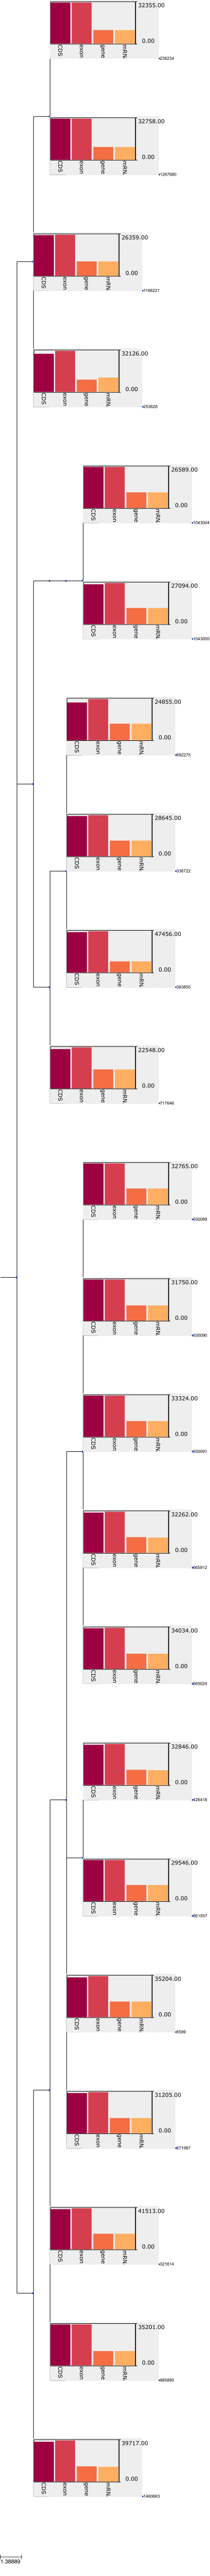

In [6]:
import sys
import random
from ete3 import Tree,NCBITaxa, faces, TreeStyle, COLOR_SCHEMES
from IPython.display import Image, display
import pandas as pd

schema_names = COLOR_SCHEMES.keys()
ncbi = NCBITaxa()

df=pd.read_csv("stats.csv", names=['taxid','CDS','CDS_Mean','exon','exon_Mean','gene','gene_Mean','mRNA','mRNA_Mean'])
taxid_list=df['taxid']

def layout(node): 
    node_Name= ncbi.translate_to_names([int(node.name)])
    if node.is_leaf():
        info=df.loc[df['taxid'] == int(node.name)].values.tolist()
        row=info[0]
        F= faces.BarChartFace([row[1],row[3],row[5],row[7]], min_value=0,
                              colors=COLOR_SCHEMES["spectral"],
                              labels = ['CDS','exon','gene','mRNA'],
                              label_fsize=10, scale_fsize=10)
        faces.add_face_to_node(F,node, 0, position="branch-top")
        F.background.color = "#eee"
        node.add_features(CDS=row[1])
        node.add_features(exon=row[3])
        node.add_features(gene=row[5])
        node.add_features(mRNA=row[7])
        node.add_features(tax2name=  str(get_name(int(node.name)) ))

        
    else:
        nodeset=set()
        nodeset.add(int(node.name))
        taxid_list=get_leaves_taxid(nodeset)
        node.add_features(GFF_No=len(taxid_list))
        info= df[df['taxid'].isin(taxid_list)]['CDS'].mean()
        node.add_features(avg_CDS=info)
        info= df[df['taxid'].isin(taxid_list)]['exon'].mean()
        node.add_features(avg_exon=info)
        info= df[df['taxid'].isin(taxid_list)]['gene'].mean()
        node.add_features(avg_gene=info)
        info= df[df['taxid'].isin(taxid_list)]['mRNA'].mean()
        node.add_features(avg_mRNA=info)


def build_tree():
    # set of internal nodes tax id
    nodeset={ 1570301, 5579, 5014, 147541}
    taxid_list=get_leaves_taxid(nodeset)
    taxid_list.update(nodeset)
    t = ncbi.get_topology(taxid_list,intermediate_nodes=False)
    
    ts = TreeStyle()
    ts.layout_fn = layout
    ts.mode = "r"
    ts.show_leaf_name = True
    
    return t, ts

if __name__ == '__main__':
    t, ts = build_tree()        
    t.render("barchart.png", w=400, tree_style=ts)
    display(Image(filename='barchart.png'))
    t.show(tree_style=ts)


## Print tree as ascii with annotation
- taxid_to-name
- exon number
- number of GFF files(leaves)

In [7]:
if __name__ == '__main__':
    t, ts = build_tree() 
    t.render("barchart.png", w=600, tree_style=ts)

    print t.get_ascii(attributes=[ "tax2name", "GFF_No", "exon"], show_internal=True)



         /-[u'Diplodia corticola'], 32355.0
      /2|
     |   \-[u'Neofusicoccum parvum UCRNP2'], 32758.0
   /4|
  |  |--[u'Coniosporium apollinis CBS 100218'], 26359.0
  |  |
  |   \-[u'Verruconis gallopava'], 32126.0
  |
  |            /-[u'Aureobasidium namibiae CBS 147.97'], 26589.0
  |   /2 /2 /2|
  |  |         \-[u'Aureobasidium subglaciale EXF-2481'], 27094.0
  |  |
  |-6|      /-[u'Sphaerulina musiva SO2202'], 24855.0
  |  |     |
  |  |   /3|--[u'Zymoseptoria tritici IPO323'], 28645.0
  |  |  |  |
  |   \4|   \-[u'Pseudocercospora fijiensis CIRAD86'], 47456.0
  |     |
  |      \-[u'Baudoinia panamericana UAMH 10762'], 22548.0
  |
-22            /-[u'Bipolaris zeicola 26-R-13'], 32765.0
  |           |
  |           |--[u'Bipolaris oryzae ATCC 44560'], 31750.0
  |           |
  |         /5|--[u'Bipolaris victoriae FI3'], 33324.0
  |        |  |
  |        |  |--[u'Bipolaris sorokiniana ND90Pr'], 32262.0
  |        |  |
  |        |   \-[u'Bipolaris maydis ATCC 48331'], 340

# Build the whole tree of
- Fungi
- Protozoa

## Statistics for leaves
- CDS
- exon
- gene 
- mRNA

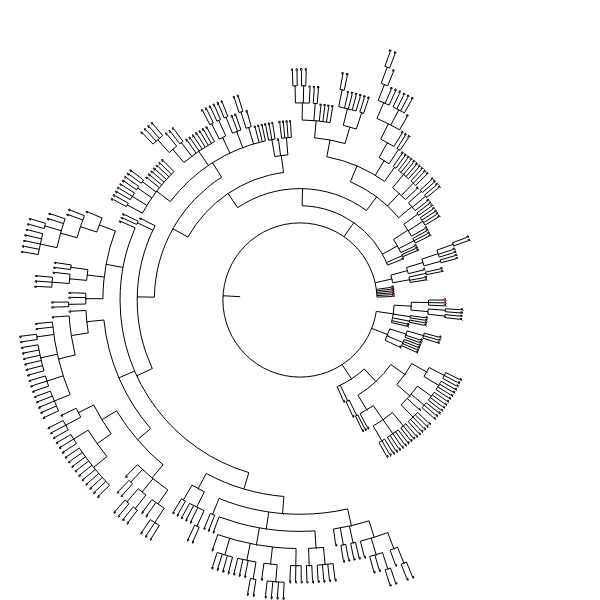

In [8]:
import sys
import random
from ete3 import Tree,NCBITaxa, faces, TreeStyle, COLOR_SCHEMES
from IPython.display import Image, display
import pandas as pd


schema_names = COLOR_SCHEMES.keys()

df=pd.read_csv("stats.csv", names=['taxid','CDS','CDS_Mean','exon','exon_Mean','gene','gene_Mean','mRNA','mRNA_Mean'])
taxid_list=df['taxid']

def layout(node):
    if node.is_leaf():
        info=df.loc[df['taxid'] == int(node.name)].values.tolist()
        #print (info[0][0])
        row=info[0]
        F= faces.BarChartFace([row[1],row[3],row[5],row[7]], min_value=0,
                              colors=COLOR_SCHEMES["spectral"],
                              labels = ['CDS','exon','gene','mRNA'],
                              label_fsize=10, scale_fsize=10)
        faces.add_face_to_node(F,node, 0, position="branch-top")
        F.background.color = "#eee"

def get_example_tree():
    
    t = ncbi.get_topology(taxid_list,intermediate_nodes=False)
    
    ts = TreeStyle()
    ts.layout_fn = layout
    ts.mode = "c"
    ts.show_leaf_name = False
    for leaf in t:
        info=df.loc[df['taxid'] == int(leaf.name)].values.tolist()
        row=info[0]
        leaf.add_features(CDS=row[1])
        leaf.add_features(exon=row[3])
        leaf.add_features(gene=row[5])
        leaf.add_features(mRNA=row[7])
    
    return t, ts

if __name__ == '__main__':
    t, ts = get_example_tree()
    t.render("piechart.png", w=600, tree_style=ts)
    display(Image(filename='piechart.png'))
    t.show(tree_style=ts)


# More visualization example

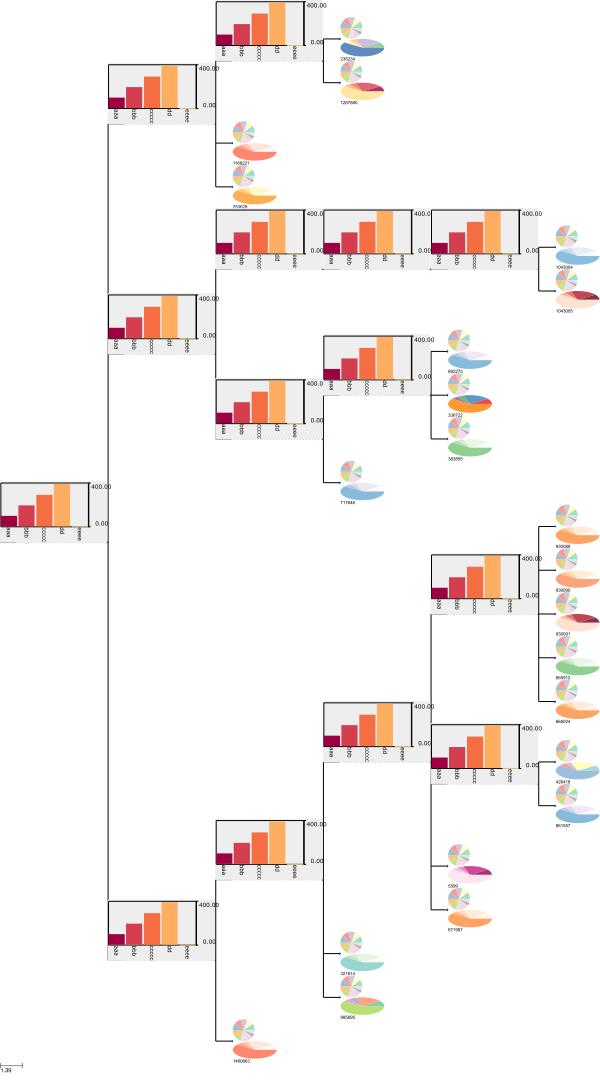

In [206]:
import sys
import random
from ete3 import Tree, faces, TreeStyle, COLOR_SCHEMES
from IPython.display import Image, display

schema_names = COLOR_SCHEMES.keys()

def layout(node):
    #print (node.name)
    if node.is_leaf():
        F= faces.PieChartFace([10,10,10,10,10,10,10,10,10,4,6],
                              colors=COLOR_SCHEMES["set3"],
                              width=50, height=50)
        F.border.width = None
        F.opacity = 0.8
        faces.add_face_to_node(F,node, 0, position="branch-right")

        F= faces.PieChartFace([10,20,5,5,60],
                              colors=COLOR_SCHEMES[random.sample(schema_names, 1)[0]],
                              width=100, height=40)
        F.border.width = None
        F.opacity = 0.8
        faces.add_face_to_node(F,node, 0, position="branch-right")
    else:
        F= faces.BarChartFace([100,200,300,400,-12], min_value=0,
                              colors=COLOR_SCHEMES["spectral"],
                              labels = "aaa,bbb,cccccc,dd,eeee,ffff,gg,HHH,II,JJJ,KK".split(","),
                              label_fsize=10, scale_fsize=10)
        faces.add_face_to_node(F,node, 0, position="branch-top")
        F.background.color = "#eee"

def build_tree():
    nodeset={ 1570301, 5579, 5014, 147541}
    taxid_list=get_leaves_taxid(nodeset)
    taxid_list.update(nodeset)
    t = ncbi.get_topology(taxid_list,intermediate_nodes=False)
    
    ts = TreeStyle()
    ts.layout_fn = layout
    ts.mode = "r"
    ts.show_leaf_name = True
    
    return t, ts

if __name__ == '__main__':
    t, ts = build_tree() 
    t.render("piechart.png", w=600, tree_style=ts)
    display(Image(filename='piechart.png'))
    t.show(tree_style=ts)


In [ ]:
import random
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, TreeFace
from IPython.display import Image, display

# Tree Style used to render small trees used as leaf faces
small_ts = TreeStyle()
small_ts.show_leaf_name = True
small_ts.scale = 10

def layout(node):
    if node.is_leaf():
        # Add node name to laef nodes
        N = AttrFace("name", fsize=14, fgcolor="black")
        faces.add_face_to_node(N, node, 0)

        t = Tree()
        t.populate(10)

        T = TreeFace(t, small_ts)
        # Let's make the sphere transparent
        T.opacity = 0.8
        # And place as a float face over the tree
        faces.add_face_to_node(T, node, 1, position="aligned")

def get_example_tree():
    # Random tree
    t = Tree()
    t.populate(20, random_branches=True)

    # Some random features in all nodes
    for n in t.traverse():
        n.add_features(weight=random.randint(0, 50))

    # Create an empty TreeStyle
    ts = TreeStyle()

    # Set our custom layout function
    ts.layout_fn = layout

    # Draw a tree
    ts.mode = "c"

    # We will add node names manually
    ts.show_leaf_name = False
    # Show branch data
    ts.show_branch_length = True
    ts.show_branch_support = True
    return t, ts

if __name__ == "__main__":
    t, ts = get_example_tree()
    t.render("tree_faces.png", w=600, dpi=300, tree_style=ts)
    display(Image('tree_faces.png'))
    #t.show(tree_style=ts)



# Thank you!

In [ ]:
from ete3 import PhyloTree
t = PhyloTree("((((Human_1, Chimp_1), (Human_2, (Chimp_2, Chimp_3))), ((Fish_1, (Human_3, Fish_3)), Yeast_2)), Yeast_1);")
t.set_species_naming_function(lambda node: node.name.split("_")[0] )

print t.get_ascii(attributes=["name", "species"], show_internal=False )

#            /-Human_1, Human
#          /-|
#         |   \-Chimp_1, Chimp
#       /-|
#      |  |   /-Human_2, Human
#      |   \-|
#      |     |   /-Chimp_2, Chimp
#      |      \-|
#    /-|         \-Chimp_3, Chimp
#   |  |
#   |  |      /-Fish_1, Fish
#   |  |   /-|
#   |  |  |  |   /-Human_3, Human
# --|   \-|   \-|
#   |     |      \-Fish_3, Fish
#   |     |
#   |      \-Yeast_2, Yeast
#   |
#    \-Yeast_1, Yeast

t2 = t.collapse_lineage_specific_expansions()
print t2.get_ascii(attributes=["name", "species"], show_internal=False )

#             /-Human_1, Human
#          /-|
#         |   \-Chimp_1, Chimp
#       /-|
#      |  |   /-Human_2, Human
#      |   \-|
#      |      \-Chimp_2, Chimp   ***
#    /-|
#   |  |      /-Fish_1, Fish
#   |  |   /-|
#   |  |  |  |   /-Human_3, Human
# --|   \-|   \-|
#   |     |      \-Fish_3, Fish
#   |     |
#   |      \-Yeast_2, Yeast
#   |
#    \-Yeast_1, Yeast
t2.show()

In [ ]:
from ete3 import NCBITaxa, Tree, TreeStyle
from IPython.display import Image, display
import numpy as np
import pandas as pd

import csv

def layout(node):
    #print (node.name)
    if node.is_leaf():
        F= faces.PieChartFace([10,10,10,10,10,10,10,10,10,4,6],
                              colors=COLOR_SCHEMES["set3"],
                              width=50, height=50)
        F.border.width = None
        F.opacity = 0.8
        faces.add_face_to_node(F,node, 0, position="branch-right")

        F= faces.PieChartFace([10,20,5,5,60],
                              colors=COLOR_SCHEMES[random.sample(schema_names, 1)[0]],
                              width=100, height=40)
        F.border.width = None
        F.opacity = 0.8
        faces.add_face_to_node(F,node, 0, position="branch-right")
    else:
        F= faces.BarChartFace([40,20,70,100,30,40,50,40,70,-12], min_value=-12,
                              colors=COLOR_SCHEMES["spectral"],
                              labels = "aaa,bbb,cccccc,dd,eeee,ffff,gg,HHH,II,JJJ,KK".split(","),
                              label_fsize=10, scale_fsize=10)
        faces.add_face_to_node(F,node, 0, position="branch-top")
        F.background.color = "#eee"

ncbi = NCBITaxa()
tax_list=[33154,1979279, 9927,9598, 10090,9606, 7707, 8782,1979366]
#tax_list=np.loadtxt("stats.csv", usecols=[0])
#print(tax_list)
# with open("stats.csv") as f:
#     reader = csv.reader(f)
#     for line in reader:
#         print(line)



t = ncbi.get_topology(tax_list,intermediate_nodes=False)

for node in t:
    node.add_features(tax2name=  str(get_name(int(node.name)) ))
    #node.add_features(gff_NO=len(get_leaves_taxid(int(node.name))))
print t.get_ascii(attributes=["name" ,"tax2name", "gff_NO"], show_internal=False)
t.show()


## Getting NCBI species tree topology
### annotate the tree

In [ ]:
from ete3 import NCBITaxa, Tree, TreeStyle
from IPython.display import Image, display

ncbi = NCBITaxa()
with open("ncbi_tax_id.csv") as f:
    tax_list=f.read().splitlines()
print (len(tax_list))    
tax_list=[1979279, 9927,9598, 10090,9606, 7707, 8782,1979366]
tree = ncbi.get_topology(tax_list[:1000],intermediate_nodes=False)
#print (tree)
#print tree.get_ascii(attributes=["sci_name", "rank","name"])


for node in tree:
        if node.is_leaf():    
            print ("leaf")
        else:
            print(node.name)
            print (info)


for leaf in tree:
    #print (get_name(int(leaf.name)))
    leaf.add_features(nametax=str(get_name(int(leaf.name))))
    #print (ncbi.get_lineage(n.name))
print (tree.get_ascii(attributes=["name", "nametax"], show_internal=True))

# Create an empty TreeStyle
ts = TreeStyle()
# Set our custom layout function
#ts.layout_fn = layout
# Draw a tree
ts.mode = "c"

ncbi.annotate_tree(tree, taxid_attr='name')

# show the tree in ETE browser
tree.show()
tree.render("ncbi_db.png", w=800, tree_style=ts)
display(Image("ncbi_db.png"))



In [ ]:
from ete3 import Tree, faces, AttrFace, TreeStyle, NodeStyle
from IPython.display import Image, display

def layout(node):
    if node.is_leaf():
        N = AttrFace("name", fsize=30)
        faces.add_face_to_node(N, node, 0, position="aligned")

def get_example_tree():

    # Set dashed blue lines in all leaves
    nst1 = NodeStyle()
    nst1["bgcolor"] = "LightSteelBlue"
    nst2 = NodeStyle()
    nst2["bgcolor"] = "Moccasin"
    nst3 = NodeStyle()
    nst3["bgcolor"] = "DarkSeaGreen"
    nst4 = NodeStyle()
    nst4["bgcolor"] = "Khaki"


    t = Tree("((((a1,a2),a3), ((b1,b2),(b3,b4))), ((c1,c2),c3));")
    for n in t.traverse():
        n.dist = 0

    n1 = t.get_common_ancestor("a1", "a2", "a3")
    n1.set_style(nst1)
    n2 = t.get_common_ancestor("b1", "b2", "b3", "b4")
    n2.set_style(nst2)
    n3 = t.get_common_ancestor("c1", "c2", "c3")
    n3.set_style(nst3)
    n4 = t.get_common_ancestor("b3", "b4")
    n4.set_style(nst4)
    ts = TreeStyle()
    ts.layout_fn = layout
    ts.show_leaf_name = False

    ts.mode = "c"
    ts.root_opening_factor = 1
    return t, ts

if __name__ == "__main__":
    t, ts = get_example_tree()
    t.render("node_background.png", w=400, tree_style=ts)
    display(Image(filename='node_background.png'))
    t.show(tree_style=ts)
    print (t)

In [ ]:
from ete3 import Tree
t = Tree()
t.populate(50)

node2leaves = t.get_cached_content()
print t.get_ascii(attributes=["name", "color","num"], show_internal=False)
# lets now print the size of each node without the need of
# recursively traverse
for n in t.traverse():
    print "node %s contains %s tips" %(n.name, len(node2leaves[n]))

# Automatic tree annotation using NCBI taxonomy
NCBI taxonomy annotation consists of adding additional information to any internal a leaf node in a give user tree. Only an attribute containing the taxid associated to each node is required for the nodes in the query tree. The annotation process will add the following features to the nodes:

- sci_name
- taxid
- named_lineage
- lineage
- rank

In [ ]:
from ete3 import PhyloTree

# load the whole leaf name as species taxid
tree = PhyloTree('((9606, 9598), 10090);', sp_naming_function=lambda name: name)
tax2names, tax2lineages, tax2rank = tree.annotate_ncbi_taxa()

# split names by '|' and return the first part as the species taxid
tree = PhyloTree('((9606|protA, 9598|protA), 10090|protB);', sp_naming_function=lambda name: name.split('|')[0])
tax2names, tax2lineages, tax2rank = tree.annotate_ncbi_taxa()

print tree.get_ascii(attributes=["name", "sci_name", "taxid"])


#                                             /-9606|protA, Homo sapiens, 9606
#                          /, Homininae, 207598
#-, Euarchontoglires, 314146                  \-9598|protA, Pan troglodytes, 9598
#                         |
#                          \-10090|protB, Mus musculus, 10090

## Alternatively, you can also use the NCBITaxa.annotate_tree() function to annotate a custom tree instance.



In [ ]:
from ete3 import Tree, NCBITaxa
ncbi = NCBITaxa()
tree = Tree()
tree.populate(4)

ncbi.annotate_tree(tree, taxid_attr="name")
print (tree)

## Loading PhyloXML projects from files



In [ ]:
from ete3 import Phyloxml
project = Phyloxml()
project.build_from_file("tax_ncbi.xml")

# Each tree contains the same methods as a PhyloTree object
for tree in project.get_phylogeny():
    print tree
    # you can even use rendering options
    #tree.show()
    # PhyloXML features are stored in the phyloxml_clade attribute
    for node in tree:
        #node.add_features(size=len(node))
 
        print "Node name:", node.name
        for seq in node.phyloxml_clade.get_sequence():
            for domain in seq.domain_architecture.get_domain():
                domain_data = [domain.valueOf_, domain.get_from(), domain.get_to()]
                print "  Domain:", '\t'.join(map(str, domain_data))

                
#tree.show()

## All descendants of Cellular organisms

In [ ]:
from ete3 import *
#descendants = ncbi.get_descendant_taxa('13157')
#print ncbi.translate_to_names(descendants)
tree = ncbi.get_descendant_taxa('78173', return_tree=True)
print tree.get_ascii(attributes=['taxid'])


In [ ]:
from ete3 import nexml, Nexml
nexml_tree = nexml.NexmlTree("((hello, nexml):1.51, project):0.6;")
tree_collection =  nexml.get_trees()[0]

tree_collection.add_tree(nexml_tree)
nexml_tree.show()

## Pie chart Face and Barchart Face

In [ ]:
import os
os.system('python tree1.py')

In [ ]:
import sys
import random
from ete3 import Tree, faces, TreeStyle, COLOR_SCHEMES

schema_names = COLOR_SCHEMES.keys()

def layout(node):
    if not node.is_leaf():
        size = random.randint(20,50)
        F= faces.PieChartFace([10,20,60,10],
                              colors=COLOR_SCHEMES[random.sample(schema_names, 1)[0]],
                              width=size, height=size)
        F.border.width = None
        F.opacity = 0.6
        faces.add_face_to_node(F,node, 0, position="float")

def get_example_tree():
    t = Tree()
    ts = TreeStyle()
    ts.layout_fn = layout
    ts.mode = "c"
    ts.show_leaf_name = True
    ts.min_leaf_separation = 15
    t.populate(100)
    return t, ts

if __name__ == '__main__':
    t, ts = get_example_tree()
    t.show(tree_style=ts)
    #t.render("float_piechart.png", tree_style=ts)


In [ ]:
from ete3 import NCBITaxa, Tree, TreeStyle
import numpy as np
import pandas as pd

#index_col='taxid'
df=pd.read_csv("stats.csv", names=['taxid','CDS','CDS_Mean','exon','exon_Mean','gene','gene_Mean','mRNA','mRNA_Mean'])
info=df.loc[df['taxid'] == 1043005].values.tolist()
print(info)
print(info[0][0])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data1=[1000,200,3000,4000,5000]
plt.boxplot(data1)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
myData = pd.DataFrame(np.random.rand(10, 2), columns=['MyColumn', 'blah'])

df=pd.read_csv("stats.csv", names=['CDS','exon','gene','mRNA'])

#plt.boxplot(df['CDS'], df['gene'])
df.plot.box()

plt.show()

In [ ]:
df = pd.DataFrame(np.random.rand(10, 5), columns=['A', 'B', 'C', 'D', 'E'])
df.plot.box()
plt.show()